# Cleaning data


In [64]:
import pandas as pd
import numpy as np

import datetime as dt

import warnings
warnings.filterwarnings('ignore')

**!! The current csv file doent contain whats expected to run the notebook**

In the typical DS workflow we: 
1. Access the data
2. Explore and process data
3. Extract Insights
4. Report Insights

Dirty data can appear due to wrong encoding, duplicate entries, wrong processing, etc... If the raw data is garbage, we cannot expect but garbage to be output.

## Ensuring the right data types

First thing to check is that our variables have the right datatype. 

### Strings to integers

In [37]:
ride_sharing = pd.read_csv('../data/ride_sharing_new.csv')

print(ride_sharing.info())

print(ride_sharing['user_type'].describe())

ride_sharing['user_type_cat'] = ride_sharing['user_type'].astype('category')

assert ride_sharing['user_type_cat'].dtype == 'category'

ride_sharing['user_type_cat'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25760 entries, 0 to 25759
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       25760 non-null  int64 
 1   duration         25760 non-null  object
 2   station_A_id     25760 non-null  int64 
 3   station_A_name   25760 non-null  object
 4   station_B_id     25760 non-null  int64 
 5   station_B_name   25760 non-null  object
 6   bike_id          25760 non-null  int64 
 7   user_type        25760 non-null  int64 
 8   user_birth_year  25760 non-null  int64 
 9   user_gender      25760 non-null  object
dtypes: int64(6), object(4)
memory usage: 2.0+ MB
None
count    25760.000000
mean         2.008385
std          0.704541
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: user_type, dtype: float64


count     25760
unique        3
top           2
freq      12972
Name: user_type_cat, dtype: int64

In [38]:
ride_sharing['duration']

0        12 minutes
1        24 minutes
2         8 minutes
3         4 minutes
4        11 minutes
            ...    
25755    11 minutes
25756    10 minutes
25757    14 minutes
25758    14 minutes
25759    29 minutes
Name: duration, Length: 25760, dtype: object

In [39]:
ride_sharing['duration_trim'] = ride_sharing['duration'].str.strip('minutes')

ride_sharing['duration_time'] = ride_sharing['duration_trim'].astype('int')

assert ride_sharing['duration_time'].dtype == 'int'

print(ride_sharing[['duration','duration_trim','duration_time']])
print(ride_sharing.duration_time.mean())

         duration duration_trim  duration_time
0      12 minutes           12              12
1      24 minutes           24              24
2       8 minutes            8               8
3       4 minutes            4               4
4      11 minutes           11              11
...           ...           ...            ...
25755  11 minutes           11              11
25756  10 minutes           10              10
25757  14 minutes           14              14
25758  14 minutes           14              14
25759  29 minutes           29              29

[25760 rows x 3 columns]
11.389052795031056


## Data range constraints

When the range of a certain variable is known, it can happen that there are observations outside the range.

What to do with out of range data:
- Dropping data: go for this iff the amount of impacted data is low and after understanding the root cause of the issues.
- Setting custom minimums or maximums
- Setting custom value depending on business assumptions



In [40]:
ride_sharing.describe()

,Unnamed: 0,station_A_id,station_B_id,bike_id,user_type,user_birth_year,duration_time
count,25760.000000,25760.000000,25760.000000,25760.000000,25760.000000,25760.000000,25760.000000
mean,12879.500000,31.023602,89.558579,4107.621467,2.008385,1983.054969,11.389053
std,7436.415803,26.409263,105.144103,1576.315767,0.704541,10.010992,23.500516
min,0.000000,3.000000,3.000000,11.000000,1.000000,1901.000000,1.000000
25%,6439.750000,15.000000,21.000000,3106.000000,2.000000,1978.000000,6.000000
50%,12879.500000,21.000000,58.000000,4821.000000,2.000000,1985.000000,9.000000
75%,19319.250000,67.000000,93.000000,5257.000000,3.000000,1990.000000,13.000000
max,25759.000000,81.000000,383.000000,6638.000000,3.000000,2001.000000,1372.000000


In [41]:
# The loaded dataframe dont contain tiresizes, but the idea is to cap the values going beyond the expected range to its max value.
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('int')
ride_sharing.loc[ride_sharing['tire_sizes'] > 27, 'tire_sizes'] = 27
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('category')


KeyError: 'tire_sizes'

## Handling duplicates

Duplicates happen. Often they are not exact duplicates.
They are originated because of: 
- Human errors
- Bugs and design errors on business processes or pipelines
- Joining/merging data sources

How to find duplicates?
.duplicated()

How to remove duplicates?
.drop_duplicates() 

We can use the duplicates to be removed to fulfill or improve the remaining records by using .groupby() and agg()



In [42]:
duplicates = ride_sharing.duplicated(subset=['ride_id'], keep=False)

duplicated_rides = ride_sharing[duplicates].sort_values('ride_id')

print(duplicated_rides[['ride_id','duration','user_birth_year']])

KeyError: Index(['ride_id'], dtype='object')

In [43]:
ride_dup = ride_sharing.drop_duplicates()

statistics = {'user_birth_year': 'min', 'duration': 'mean'}

ride_unique = ride_dup.groupby('ride_id').agg(statistics).reset_index()

duplicates = ride_unique.duplicated(subset = 'ride_id', keep = False)
duplicated_rides = ride_unique[duplicates == True]

assert duplicated_rides.shape[0] == 0£

SyntaxError: invalid character '£' (U+00A3) (3538104650.py, line 10)

## Categories and membership constraints

Categorical data represent variables whose values belong to predefined set of categories. Variables like "Marriage Status", "Household Income Category" or "Loan Status" belong to this category.

When feeding models, these variables are often converted into a numeric representation.

Categorical variables cannot have values outside of the predefined ones.

Inconsistencies in categorical variables may happen due to a variety of reasons: data entry errors, parsing errors...

### Identifying inconsistent categories

Before fixing the inconsistent categories we have to identify them:

In [44]:
categories = ['A', 'B', 'C']
observations = ['A', 'B', 'D'] 

inconsistent_categories = set(observations).difference(categories)

print(inconsistent_categories)

{'D'}


We can now use the 'inconsistent_categories' with the isin pandas method to find observations with inconsistent values.

How do we treat these problems?

### Dropping inconsistent categories

In [45]:
categories = pd.DataFrame({'cleanliness': {
                                0: 'Clean',
                                1: 'Average',
                                2: 'Somewhat clean',
                                3: 'Somewhat dirty',
                                4: 'Dirty'
                            },'safety': {
                                0: 'Neutral',
                                1: 'Very safe',
                                2: 'Somewhat safe',
                                3: 'Very unsafe',
                                4: 'Somewhat unsafe'
                            },'satisfaction': {
                                0: 'Very satisfied',
                                1: 'Neutral',
                                2: 'Somewhat satisfied',
                                3: 'Somewhat unsatisfied',
                                4: 'Very unsatisfied'
                            }
                          }
)

airlines = pd.read_csv('../data/airlines_final.csv')

print('Cleanliness: ', airlines['cleanliness'].unique(), "\n")
print('Safety: ', airlines['safety'].unique(), "\n")
print('Satisfaction: ', airlines['satisfaction'].unique(), "\n")

Cleanliness:  ['Clean' 'Average' 'Somewhat clean' 'Somewhat dirty' 'Dirty'] 

Safety:  ['Neutral' 'Very safe' 'Somewhat safe' 'Very unsafe' 'Somewhat unsafe'] 

Satisfaction:  ['Very satisfied' 'Neutral' 'Somewhat satsified' 'Somewhat unsatisfied'
 'Very unsatisfied'] 



In [46]:
cat_clean = set(airlines['cleanliness']).difference(categories['cleanliness'])
cat_clean_rows = airlines['cleanliness'].isin(cat_clean)
airlines[~cat_clean_rows]

,Unnamed: 0,id,day,airline,destination,dest_region,dest_size,boarding_area,dept_time,wait_min,cleanliness,safety,satisfaction
0,0,1351,Tuesday,UNITED INTL,KANSAI,Asia,Hub,Gates 91-102,2018-12-31,115.0,Clean,Neutral,Very satisfied
1,1,373,Friday,ALASKA,SAN JOSE DEL CABO,Canada/Mexico,Small,Gates 50-59,2018-12-31,135.0,Clean,Very safe,Very satisfied
2,2,2820,Thursday,DELTA,LOS ANGELES,West US,Hub,Gates 40-48,2018-12-31,70.0,Average,Somewhat safe,Neutral
3,3,1157,Tuesday,SOUTHWEST,LOS ANGELES,West US,Hub,Gates 20-39,2018-12-31,190.0,Clean,Very safe,Somewhat satsified
4,4,2992,Wednesday,AMERICAN,MIAMI,East US,Hub,Gates 50-59,2018-12-31,559.0,Somewhat clean,Very safe,Somewhat satsified
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,2804,1475,Tuesday,ALASKA,NEW YORK-JFK,East US,Hub,Gates 50-59,2018-12-31,280.0,Somewhat clean,Neutral,Somewhat satsified
2473,2805,2222,Thursday,SOUTHWEST,PHOENIX,West US,Hub,Gates 20-39,2018-12-31,165.0,Clean,Very safe,Very satisfied
2474,2806,2684,Friday,UNITED,ORLANDO,East US,Hub,Gates 70-90,2018-12-31,92.0,Clean,Very safe,Very satisfied
2475,2807,2549,Tuesday,JETBLUE,LONG BEACH,West US,Small,Gates 1-12,2018-12-31,95.0,Clean,Somewhat safe,Very satisfied


### Other errors when dealing with categorical variables

#### Value inconsistency
Due to trailing spaces, wrong casing, spaces...

We can str.upper() or str.lower() case to solve casing issues.

str.strip() will solve the trailing spaces problem

In [47]:
print(airlines['dest_region'].unique())
print(airlines['dest_size'].unique())

['Asia' 'Canada/Mexico' 'West US' 'East US' 'Midwest US' 'EAST US'
 'Middle East' 'Europe' 'eur' 'Central/South America'
 'Australia/New Zealand' 'middle east']
['Hub' 'Small' '    Hub' 'Medium' 'Large' 'Hub     ' '    Small'
 'Medium     ' '    Medium' 'Small     ' '    Large' 'Large     ']


In [48]:
airlines['dest_region'] = airlines['dest_region'].str.lower()
airlines['dest_region'] = airlines['dest_region'].replace({'eur':'europe'})

airlines['dest_size'] = airlines['dest_size'].str.strip()

In [49]:
print(airlines['dest_region'].unique())
print(airlines['dest_size'].unique())

['asia' 'canada/mexico' 'west us' 'east us' 'midwest us' 'middle east'
 'europe' 'central/south america' 'australia/new zealand']
['Hub' 'Small' 'Medium' 'Large']


#### Too many categories

Often collapsable into few.

For splitting into new categories there are two options: qcut (dumber) and cut (smarter). 

If we want to collapse already existing categories grouping them we can use the replace method.

In [53]:
airlines.day.unique()

array(['Tuesday', 'Friday', 'Thursday', 'Wednesday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [55]:
airlines.wait_min.describe()

count    2477.000000
mean      166.084376
std       107.643625
min        15.000000
25%       105.000000
50%       145.000000
75%       185.000000
max      1365.000000
Name: wait_min, dtype: float64

In [50]:
label_ranges = [0, 60, 180, np.inf]
label_names = ['short', 'medium', 'long']

airlines['wait_type'] = pd.cut(airlines['wait_min'], bins = label_ranges, 
                                labels = label_names)

In [51]:
mappings = {'Monday':'weekday', 'Tuesday':'weekday', 'Wednesday': 'weekday', 
            'Thursday': 'weekday', 'Friday': 'weekday', 
            'Saturday': 'weekend', 'Sunday': 'weekend'}

airlines['day_week'] = airlines['day'].replace(mappings)

## Cleaning text data

Text data is very frequent.

Typical errors are typos, casing, excesive length, different formats...

Regular expressions is a powerful tool for fixing these issues.

In [56]:
airlines['full_name'] = airlines['full_name'].str.replace("Dr.","")
airlines['full_name'] = airlines['full_name'].str.replace("Mr.","")
airlines['full_name'] = airlines['full_name'].str.replace("Miss","")
airlines['full_name'] = airlines['full_name'].str.replace("Ms.","")

assert airlines['full_name'].str.contains('Ms.|Mr.|Miss|Dr.').any() == False

KeyError: 'full_name'

In [58]:
resp_length = airlines['survey_response'].str.len()

airlines_survey = airlines[resp_length > 40]

assert airlines_survey['survey_response'].str.len().min() > 40

print(airlines_survey['survey_response'])

KeyError: 'survey_response'

## Uniformity

Ensuring unit uniformity is paramount. Currency, temperatures, distances... are prone to have different units through datasets.

Dates can have multiple formats too. Sometimes, specific dates can be ambiguous.

Its very important to understand where the data is coming from.


In [59]:
banking = pd.read_csv('../data/banking_dirty.csv')

In [ ]:
acct_eu = banking['acct_cur'] == 'euro'

# Convert acct_amount where it is in euro to dollars
banking.loc[acct_eu, 'acct_amount'] = banking.loc[acct_eu, 'acct_amount'] * 1.1

# Unify acct_cur column by changing 'euro' values to 'dollar'
banking.loc[acct_eu, 'acct_cur'] = 'dollar'

# Assert that only dollar currency remains
assert banking['acct_cur'].unique() == 'dollar'

In [60]:
print(banking['account_opened'].head())

banking['account_opened'] = pd.to_datetime(banking['account_opened'],
                                           # Infer datetime format
                                           infer_datetime_format = True,
                                           # Return missing value for error
                                           errors = 'coerce') 

banking['acct_year'] = banking['account_opened'].dt.strftime('%Y')

print(banking['acct_year'])

0    02-09-18
1    28-02-19
2    25-04-18
3    07-11-17
4    14-05-18
Name: account_opened, dtype: object
0     2018
1     2019
2     2018
3     2017
4     2018
      ... 
95    2018
96    2017
97    2017
98    2017
99    2017
Name: acct_year, Length: 100, dtype: object


/var/folders/tx/44c409ls4bvf__rjhb2qjmf40000gn/T/ipykernel_3249/3102869659.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  banking['account_opened'] = pd.to_datetime(banking['account_opened'],
/var/folders/tx/44c409ls4bvf__rjhb2qjmf40000gn/T/ipykernel_3249/3102869659.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  banking['account_opened'] = pd.to_datetime(banking['account_opened'],


### Cross Field Validation 

Cross field validation refers to the usage of multiple fields in a dataset to sanity check data integrity. This is often required when merging different datasets comming from different sources.

In case of inconsistencies, many options can be taken into account, all of them requiring a deep understanding about where the data is comming from.


In [62]:
fund_columns = ['fund_A', 'fund_B', 'fund_C', 'fund_D']

inv_equ = banking[fund_columns].sum(axis=1) == banking['inv_amount']

consistent_inv = banking[inv_equ]
inconsistent_inv = banking[~inv_equ]

print("Number of inconsistent investments: ", inconsistent_inv.shape[0])

Number of inconsistent investments:  8


In [70]:
today = dt.date.today()
banking['birth_date'] = pd.to_datetime(banking['birth_date'])

ages_manual = 2020 - banking['birth_date'].dt.year

# Find rows where age column == ages_manual
age_equ = banking['Age'] == ages_manual

# Store consistent and inconsistent data
consistent_ages = banking[age_equ]
inconsistent_ages = banking[~age_equ]

# Store consistent and inconsistent data
print("Number of inconsistent ages: ", inconsistent_ages.shape[0])

Number of inconsistent ages:  8


In [71]:
banking

,Unnamed: 0,cust_id,birth_date,Age,acct_amount,inv_amount,fund_A,fund_B,fund_C,fund_D,account_opened,last_transaction,acct_year
0,0,870A9281,1962-06-09,58,63523.31,51295,30105.0,4138.0,1420.0,15632.0,2018-02-09,22-02-19,2018
1,1,166B05B0,1962-12-16,58,38175.46,15050,4995.0,938.0,6696.0,2421.0,2019-02-28,31-10-18,2019
2,2,BFC13E88,1990-09-12,34,59863.77,24567,10323.0,4590.0,8469.0,1185.0,2018-04-25,02-04-18,2018
3,3,F2158F66,1985-11-03,35,84132.10,23712,3908.0,492.0,6482.0,12830.0,2017-07-11,08-11-18,2017
4,4,7A73F334,1990-05-17,30,120512.00,93230,12158.4,51281.0,13434.0,18383.0,2018-05-14,19-07-18,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,CA507BA1,1974-08-10,46,12209.84,7515,190.0,931.0,1451.0,4943.0,2018-05-26,11-09-19,2018
96,96,B99CD662,1989-12-12,31,92838.44,49089,2453.0,7892.0,31486.0,7258.0,2017-04-05,12-03-19,2017
97,97,13770971,1984-11-29,36,92750.87,27962,3352.0,7547.0,8486.0,8577.0,2017-08-16,24-04-19,2017
98,98,93E78DA3,1969-12-14,51,41942.23,29662,1758.0,11174.0,11650.0,5080.0,2017-09-10,15-04-18,2017


### Completeness and missing data

Missing data occurs when no data value is stored for a variable in an observation. Can be represented as NaN, NA, 0...

There are multiple reasons behind missing data.


In [73]:
# To get an idea about missingness
banking.isna().sum()

Unnamed: 0          0
cust_id             0
birth_date          0
Age                 0
acct_amount         0
inv_amount          0
fund_A              0
fund_B              0
fund_C              0
fund_D              0
account_opened      0
last_transaction    0
acct_year           0
dtype: int64

There is no null value in this dataframe

The **missingno** package allows us to better understand our missing data.

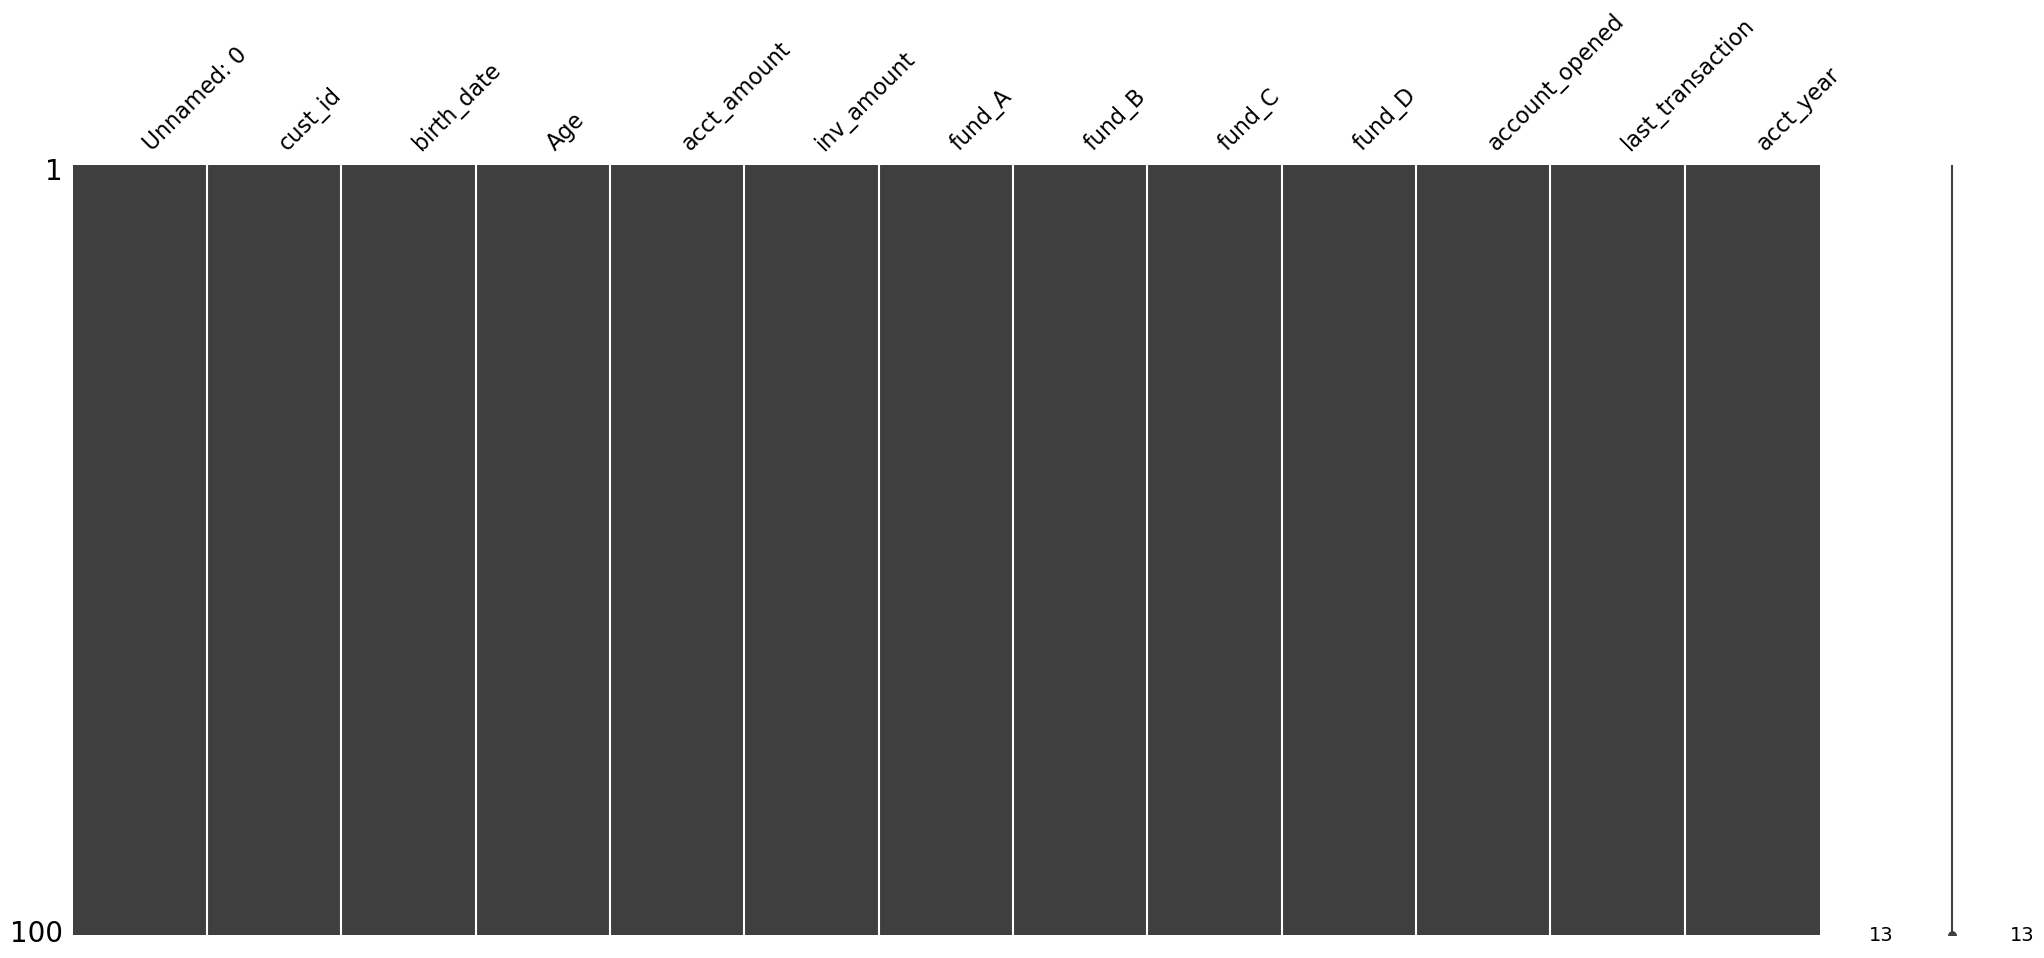

In [74]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(banking)
plt.show()

Missing values can happen:
- Completely at random: completely due to randomness
- At random: there is a relationship between missing data and other observed values
- Not at random: there is a systematic relationship between missing data and unobserved values

Again, there are many ways to proceed with missing data: dropping it, imputing means, medians or modes, imputing based on machine learning models, impute them by hand if we have sufficient domain knowledge...

## Record Linkage

**Minimum edit distance**: least possible amount of steps needed to transition from one string to another, operations being insertion, deletion, substitution or transposition. The smaller the minimum edit distance, the closer the 2 words are. There are several algorithms to calculate this distance.

Several packages to calculate these distances: thefuzz, nltk, recordlinkage...


In [76]:
restaurants = pd.read_csv('../data/restaurants_L2_dirty.csv')
restaurants

,Unnamed: 0,name,addr,city,phone,type
0,0,kokomo,6333 w. third st.,la,2139330773,american
1,1,feenix,8358 sunset blvd. west,hollywood,2138486677,american
2,2,parkway,510 s. arroyo pkwy .,pasadena,8187951001,californian
3,3,r-23,923 e. third st.,los angeles,2136877178,japanese
4,4,gumbo,6333 w. third st.,la,2139330358,cajun/creole
...,...,...,...,...,...,...
77,77,feast,1949 westwood blvd.,west la,3104750400,chinese
78,78,mulberry,17040 ventura blvd.,encino,8189068881,pizza
79,79,matsuhissa,129 n. la cienega blvd.,beverly hills,3106599639,asian
80,80,jiraffe,502 santa monica blvd,santa monica,3109176671,californian


In [84]:
from thefuzz import process

unique_types = restaurants.type.unique()

print(process.extract('asian', unique_types, limit = len(unique_types)))
print(process.extract('american', unique_types, limit = len(unique_types)))
print(process.extract('italian', unique_types, limit = len(unique_types)))

[('asian', 100), ('indonesian', 80), ('californian', 68), ('italian', 67), ('russian', 67), ('american', 62), ('japanese', 54), ('mexican/tex-mex', 54), ('american ( new )', 54), ('mexican', 50), ('fast food', 45), ('middle eastern', 43), ('steakhouses', 40), ('pacific new wave', 40), ('pizza', 40), ('diners', 36), ('cajun/creole', 36), ('vietnamese', 36), ('continental', 36), ('seafood', 33), ('chicken', 33), ('chinese', 33), ('hot dogs', 30), ('hamburgers', 30), ('coffee shops', 30), ('noodle shops', 30), ('southern/soul', 30), ('desserts', 30), ('eclectic', 26), ('coffeebar', 26), ('health food', 22), ('french ( new )', 22), ('delis', 20)]
[('american', 100), ('american ( new )', 90), ('mexican', 80), ('mexican/tex-mex', 72), ('asian', 62), ('italian', 53), ('russian', 53), ('californian', 53), ('middle eastern', 51), ('southern/soul', 47), ('pacific new wave', 45), ('hamburgers', 44), ('indonesian', 44), ('cajun/creole', 42), ('chicken', 40), ('pizza', 40), ('japanese', 38), ('ecle

In [85]:
print(restaurants['type'].unique())

['american' 'californian' 'japanese' 'cajun/creole' 'hot dogs' 'diners'
 'delis' 'hamburgers' 'seafood' 'italian' 'coffee shops' 'russian'
 'steakhouses' 'mexican/tex-mex' 'noodle shops' 'mexican' 'middle eastern'
 'asian' 'vietnamese' 'health food' 'american ( new )' 'pacific new wave'
 'indonesian' 'eclectic' 'chicken' 'fast food' 'southern/soul' 'coffeebar'
 'continental' 'french ( new )' 'desserts' 'chinese' 'pizza']


In [86]:
matches = process.extract('italian', restaurants['type'], limit=len(restaurants))

# Inspect the first 5 matches
print(matches[0:5])

[('italian', 100, 14), ('italian', 100, 21), ('italian', 100, 47), ('italian', 100, 57), ('italian', 100, 73)]


In [88]:
matches = process.extract('italian', restaurants['type'], limit=len(restaurants.type))

for match in matches:
  if match[1] >= 80:
    restaurants.loc[restaurants['type'] == match[0]] = 'italian'

In [89]:
for cuisine in categories:  
  # Create a list of matches, comparing cuisine with the cuisine_type column
  matches = process.extract(cuisine, restaurants['type'], limit=len(restaurants.type))

  # Iterate through the list of matches
  for match in matches:
     # Check whether the similarity score is greater than or equal to 80
    if match[1] >= 80:
      # If it is, select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
      restaurants.loc[restaurants['type'] == match[0]] = cuisine
      
# Inspect the final result
print(restaurants['type'].unique())

['american' 'californian' 'japanese' 'cajun/creole' 'hot dogs' 'diners'
 'delis' 'hamburgers' 'seafood' 'italian' 'coffee shops' 'russian'
 'steakhouses' 'mexican/tex-mex' 'noodle shops' 'mexican' 'middle eastern'
 'asian' 'vietnamese' 'health food' 'american ( new )' 'pacific new wave'
 'indonesian' 'eclectic' 'chicken' 'fast food' 'southern/soul' 'coffeebar'
 'continental' 'french ( new )' 'desserts' 'chinese' 'pizza']


**Record Linkage** is the act of linking data from different sources regarding the same entity. Generally, we clean two or more DataFrames, generate pairs of potentially matching records, score these pairs according to string similarity and other similarity metrics, and link them. All of these steps can be achieved with the recordlinkage package

https://recordlinkage.readthedocs.io/en/latest/

### Generating pairs
First step for record linkage: composing candidate pairs for further comparison.
Blocking is the technique to reduce the amount of pairs based on variables having the same value on both observations of the same pair.


In [93]:
import recordlinkage 

indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)

NameError: name 'restaurants_new' is not defined

### Comparing fields

In [94]:
comp_cl = recordlinkage.Compare()

# Find exact matches on city, cuisine_types 
comp_cl.exact('city', 'city', label='city')
comp_cl.exact('type', 'type', label = 'cuisine_type')

# Find similar matches of rest_name
comp_cl.string('rest_name', 'rest_name', label='name', threshold = 0.8) 

potential_matches = comp_cl.compute(pairs, restaurants, restaurants_new)
print(potential_matches)


NameError: name 'pairs' is not defined

### Linking dataframes

In [ ]:
matches = potential_matches[potential_matches.sum(axis = 1) >= 3]

# Get values of second column index of matches
matching_indices = matches.index.get_level_values(1)

# Subset restaurants_new based on non-duplicate values
non_dup = restaurants_new[~restaurants_new.index.isin(matching_indices)]

# Append non_dup to restaurants
full_restaurants = restaurants.append(non_dup)
print(full_restaurants)

